# MNIST Data

In [1]:
# load data

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

bs = 16

mnist_transform = transforms.Compose([transforms.ToTensor()])

mnist_train_dataset = torchvision.datasets.MNIST('../data/', train=True, download=True, transform=mnist_transform)
mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=bs, shuffle=True, num_workers=4)
mnist_test_dataset = torchvision.datasets.MNIST('../data/', train=False, download=True, transform=mnist_transform)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=bs, shuffle=True, num_workers=4)

torch.Size([16, 1, 28, 28])


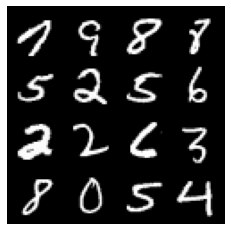

In [2]:
# display image
import matplotlib.pyplot as plt

mnist_sample = next(iter(mnist_train_loader))
mnist_imgs, mnist_lbls = mnist_sample
print(mnist_imgs.size())
collage = torchvision.utils.make_grid(mnist_imgs, nrow=int(bs ** 0.5), normalize=True).permute(1, 2, 0)
plt.axis('off')
plt.imshow(collage, )

# InfoGAN

In [3]:
import torch
import torch.nn as nn

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
# reference to PyTorch implementation of InfoGAN
# https://github.com/Natsu6767/InfoGAN-PyTorch/blob/master/models/mnist_model.py

# define generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(72, 1024, 1, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 128, 7, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 4, 2, padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)
    
# define discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 1024, 7, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1)
        )
        
        self.QHead = nn.Sequential(
            nn.Conv2d(1024, 128, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 10, 1)
        )
        
        self.DHead = nn.Sequential(
            nn.Conv2d(1024, 1, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.shared(x)
        d = self.DHead(x)
        q = self.QHead(x)    # only discrete code for simple demonstration
        
        return d, q


# Train

In [6]:
# define args
from easydict import EasyDict as edict

args = edict({
    'lr': 2e-4,
    'epochs': 50,
    'device': 'cuda',
})

In [7]:
# util funcs
def generate_noise(bs, z_dim=62, c_dim=10, fix=None):
    z = torch.randn((bs, z_dim, 1, 1))
    if fix is None:
        idx = torch.randint(0, c_dim, (bs, ))
    else:
        idx = torch.full((bs, ), fix)
    c = torch.zeros(bs, c_dim, 1, 1)
    c[range(bs), idx] = 1
    
    noise = torch.cat((z, c), dim=1)
    return noise, idx

import os
os.makedirs('model_checkpoint/', exist_ok=True)

def save_model(epoch):
    torch.save({
        'generator': generator.state_dict(),
        'discriminator': discriminator.state_dict(),
        'optimD': optimD.state_dict(),
        'optimG': optimG.state_dict(),
    }, f'model_checkpoint/info_gan_{epoch}.pt')

In [8]:
import itertools
import torch
import torch.nn as nn
import torch.optim as optim

# init models

generator = Generator().to(args.device)
generator.apply(weights_init)
discriminator = Discriminator().to(args.device)
discriminator.apply(weights_init)

criterion_gan = nn.BCELoss()             # GAN Loss
criterion_aux = nn.CrossEntropyLoss()    # Auxilary Loss

optimG = optim.Adam(itertools.chain(generator.parameters(), discriminator.QHead.parameters()), lr=args.lr)
optimD = optim.Adam(itertools.chain(discriminator.shared.parameters(), discriminator.DHead.parameters()), lr=args.lr)

real = 1.0
fake = 0.0

lossD_record = []
lossG_record = []

### Note
_If you want to skip the training phase, feel free to skip this step and use the checkpoint provided_

In [9]:
itr = 0
for epoch in range(args.epochs):
    for batch_idx, batch_item in enumerate(mnist_train_loader):

        real_data, _ = batch_item
        real_data = real_data.to(args.device)
        bs = real_data.size()[0]

        # 1. Update Discriminator
        optimD.zero_grad()

        # loss on real data
        real_pred, _ = discriminator(real_data)
        real_label = torch.tensor(real).expand_as(real_pred).to(args.device)

        # loss on fake data
        noise, aux_idx = generate_noise(bs)
        noise = noise.to(args.device)
        aux_idx = aux_idx.to(args.device)

        fake_data = generator(noise)
        fake_pred, _ = discriminator(fake_data.detach())
        fake_label = torch.tensor(fake).expand_as(fake_pred).to(args.device)

        lossD = (criterion_gan(real_pred, real_label) + criterion_gan(fake_pred, fake_label)) * 0.5
        lossD.backward()
        optimD.step()

        # 2. Update Generator
        optimG.zero_grad()

        fake_pred, aux_pred = discriminator(fake_data)
        fake_label = torch.tensor(real).expand_as(fake_pred).to(args.device)    # minimax, opposite label required

        lossG = criterion_gan(fake_pred, fake_label) + criterion_aux(aux_pred.squeeze(), aux_idx)
        lossG.backward()
        optimG.step()

        # 3. Record losses
        lossD_record.append(lossD.item())
        lossG_record.append(lossG.item())
        
        itr += 1
        if itr % 1000 == 0:
            print("*" * 40)
            print(f"{itr} / {args.epochs * len(mnist_train_loader)}")
            print(f"Discriminator Loss: {round(lossD.item(), 5)}")
            print(f"Generator     Loss: {round(lossG.item(), 5)}")
    if (epoch + 1) % 10 == 0:
        save_model(epoch)


****************************************
1000 / 187500
Discriminator Loss: 0.41644
Generator     Loss: 1.57034
****************************************
2000 / 187500
Discriminator Loss: 0.43492
Generator     Loss: 1.19071
****************************************
3000 / 187500
Discriminator Loss: 0.51181
Generator     Loss: 1.2651
****************************************
4000 / 187500
Discriminator Loss: 0.47542
Generator     Loss: 1.06623
****************************************
5000 / 187500
Discriminator Loss: 0.46055
Generator     Loss: 1.09121
****************************************
6000 / 187500
Discriminator Loss: 0.51434
Generator     Loss: 1.15245
****************************************
7000 / 187500
Discriminator Loss: 0.68246
Generator     Loss: 1.14504
****************************************
8000 / 187500
Discriminator Loss: 0.72997
Generator     Loss: 0.8908
****************************************
9000 / 187500
Discriminator Loss: 0.60035
Generator     Loss: 1.08115
***

# Result

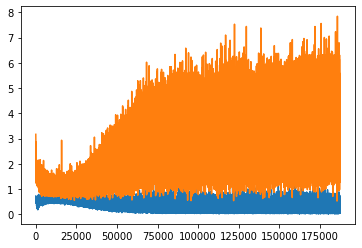

In [10]:
plt.plot(lossD_record)
plt.plot(lossG_record)

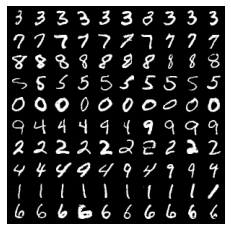

In [9]:
ckpt = torch.load('model_checkpoint/info_gan_49.pt')
generator.load_state_dict(ckpt['generator'])
generator.eval()
generator.to('cpu')
noises = []
for i in range(10):
    n, _ = generate_noise(10, fix=i)
    noises.append(n)
    
noise = torch.cat(noises, dim=0)
with torch.no_grad():
    imgs = generator(noise).detach()
result = torchvision.utils.make_grid(imgs, nrow=10)
plt.axis('off')
plt.imshow(result.permute(1, 2, 0))
plt.savefig('result.png')